In [4]:
import os, shutil
train_dir = '../train'
validation_dir = '../validation'
test_dir = '../test'

In [5]:
from keras.utils import image_dataset_from_directory

IMG_SIZE = 150

train_dataset = image_dataset_from_directory(train_dir,label_mode='categorical',image_size=(IMG_SIZE, IMG_SIZE))
validation_dataset = image_dataset_from_directory(validation_dir,label_mode='categorical',image_size=(IMG_SIZE, IMG_SIZE))
test_dataset = image_dataset_from_directory(test_dir,label_mode='categorical',image_size=(IMG_SIZE, IMG_SIZE))

Found 40000 files belonging to 10 classes.
Found 10000 files belonging to 10 classes.
Found 10000 files belonging to 10 classes.


In [6]:
from tensorflow import keras
from keras import layers
import tensorflow as tf
# Função para calcular o tamanho do dataset
def calculate_dataset_size(dataset):
    dataset_size = tf.data.experimental.cardinality(dataset).numpy()
    return dataset_size

# Função para dividir o dataset em três subsets
def split_dataset(dataset, fractions):
    dataset_size = calculate_dataset_size(dataset)
    split_sizes = [int(fraction * dataset_size) for fraction in fractions]
    
    dataset_1 = dataset.take(split_sizes[0])
    dataset_2 = dataset.skip(split_sizes[0]).take(split_sizes[1])
    dataset_3 = dataset.skip(split_sizes[0] + split_sizes[1])
    
    return dataset_1, dataset_2, dataset_3

# Frações do dataset que você quer dividir (devem somar 1)
fractions = [0.4, 0.3, 0.3]

# Dividir o dataset de treinamento em três subsets
train_dataset_1, train_dataset_2, train_dataset_3 = split_dataset(train_dataset, fractions)
validation_dataset_1, validation_dataset_2, validation_dataset_3 = split_dataset(validation_dataset, fractions)

# Calculando os tamanhos dos subsets de treinamento
split_train_size_1 = calculate_dataset_size(train_dataset_1)
split_train_size_2 = calculate_dataset_size(train_dataset_2)
split_train_size_3 = calculate_dataset_size(train_dataset_3)

# Calculando os tamanhos dos subsets de validação
split_validation_size_1 = calculate_dataset_size(validation_dataset_1)
split_validation_size_2 = calculate_dataset_size(validation_dataset_2)
split_validation_size_3 = calculate_dataset_size(validation_dataset_3)

# Mostrando os tamanhos dos subsets de treinamento
print(f"Tamanho do subset 1 do conjunto de treinamento: {split_train_size_1}")
print(f"Tamanho do subset 2 do conjunto de treinamento: {split_train_size_2}")
print(f"Tamanho do subset 3 do conjunto de treinamento: {split_train_size_3}")

# Mostrando os tamanhos dos subsets de validação
print(f"Tamanho do subset 1 do conjunto de validação: {split_validation_size_1}")
print(f"Tamanho do subset 2 do conjunto de validação: {split_validation_size_2}")
print(f"Tamanho do subset 3 do conjunto de validação: {split_validation_size_3}")

Tamanho do subset 1 do conjunto de treinamento: 500
Tamanho do subset 2 do conjunto de treinamento: 375
Tamanho do subset 3 do conjunto de treinamento: 375
Tamanho do subset 1 do conjunto de validação: 125
Tamanho do subset 2 do conjunto de validação: 93
Tamanho do subset 3 do conjunto de validação: 95


In [9]:
from keras.applications.vgg19 import VGG19


#código para ignorar o certificado digital do link seguinte
import ssl
import requests

# Disable SSL certificate verification
requests.packages.urllib3.disable_warnings()
ssl._create_default_https_context = ssl._create_unverified_context
#fim do erro do certificado-------------------

conv_base = VGG19(weights="imagenet", include_top=False) 
conv_base.trainable = False

80134624/80134624 [==============================] - 2s 0us/step


In [10]:
from tensorflow import keras
from keras import layers

data_augmentation = keras.Sequential(
[
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.2),
        layers.RandomContrast(0.2),
        layers.RandomBrightness(0.2),
        layers.RandomTranslation(height_factor=0.1, width_factor=0.1),
        layers.RandomHeight(factor=0.2),
        layers.RandomWidth(factor=0.2),
])

inputs = keras.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
x = data_augmentation(inputs)
x = keras.applications.vgg19.preprocess_input(x) 
x = conv_base(x)
x = layers.Flatten()(x)
x = layers.Dense(512)(x)
x = layers.Dropout(0.5)(x)
x = layers.Dense(256)(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(10, activation="softmax")(x) 
model = keras.Model(inputs, outputs)

In [11]:
#A partir deste bloco iremos treinar o modelo para os sub datasets
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import optimizers
from tensorflow.keras.callbacks import ReduceLROnPlateau

model.compile(loss='categorical_crossentropy', optimizer=optimizers.Adam(learning_rate=1e-4), metrics=['accuracy']) 

early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-6, verbose=1)

In [12]:
history = model.fit(train_dataset_2, epochs=2, validation_data=validation_dataset_2, batch_size=64, callbacks=[early_stopping, reduce_lr])

Epoch 1/2
375/375 [==============================] - 47s 122ms/step - loss: 32.3012 - accuracy: 0.2328 - val_loss: 10.2286 - val_accuracy: 0.4889 - lr: 1.0000e-04
Epoch 2/2
375/375 [==============================] - 45s 119ms/step - loss: 23.3972 - accuracy: 0.3128 - val_loss: 8.5403 - val_accuracy: 0.5276 - lr: 1.0000e-04


In [13]:
history = model.fit(train_dataset_1, epochs=2, validation_data=validation_dataset_1, batch_size=64, callbacks=[early_stopping, reduce_lr]) 

Epoch 1/2


500/500 [==============================] - 59s 118ms/step - loss: 19.9576 - accuracy: 0.3319 - val_loss: 7.3000 - val_accuracy: 0.5587 - lr: 1.0000e-04
Epoch 2/2
500/500 [==============================] - 61s 121ms/step - loss: 17.1834 - accuracy: 0.3387 - val_loss: 6.4238 - val_accuracy: 0.5655 - lr: 1.0000e-04


In [14]:
val_loss, val_acc = model.evaluate(validation_dataset)
print('val_acc:', val_acc)
model.save('models/ModelT_transferLearning_featureExtraction_WithDataAumentation_OnlyClassification.h5')

313/313 [==============================] - 29s 93ms/step - loss: 6.4675 - accuracy: 0.5625
val_acc: 0.5625


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [15]:
import matplotlib.pyplot as plt
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

KeyError: 'acc'

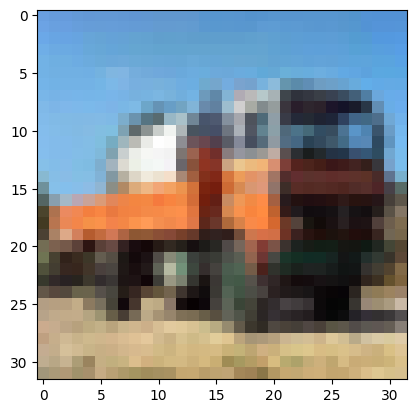

1/1 [==============================] - 0s 90ms/step
Predicted vector: [[0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]]
Actual class: 009_truck ---- Predicted class: Truck
Predicted probabilities: [1.35410475e-04 2.63869097e-05 1.13191634e-09 2.22233815e-10
 2.12649148e-10 1.59812372e-11 4.01937424e-12 1.08758115e-07
 1.36273984e-05 9.99824584e-01]


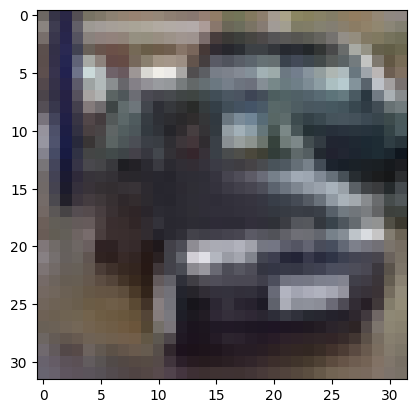

1/1 [==============================] - 0s 11ms/step
Predicted vector: [[0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]]
Actual class: 001_automobile ---- Predicted class: Automobile
Predicted probabilities: [2.8005525e-07 9.9651068e-01 1.6109188e-09 4.4718953e-09 4.6194021e-10
 9.4464170e-10 6.0559575e-09 1.0682798e-09 1.5568502e-06 3.4875504e-03]


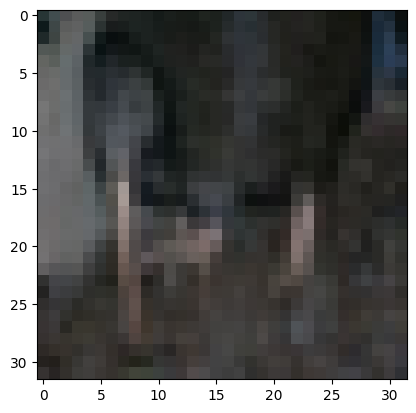

1/1 [==============================] - 0s 10ms/step
Predicted vector: [[0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]]
Actual class: 002_bird ---- Predicted class: Deer
Predicted probabilities: [3.0081996e-04 4.5672940e-07 9.1696322e-02 1.4687896e-01 7.2692782e-01
 2.0995462e-02 9.0488335e-03 4.1181985e-03 8.6958762e-06 2.4496088e-05]


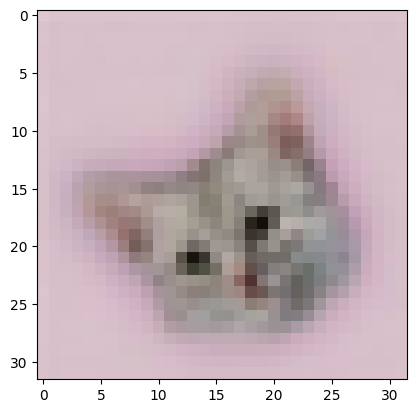

1/1 [==============================] - 0s 11ms/step
Predicted vector: [[0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]]
Actual class: 003_cat ---- Predicted class: Dog
Predicted probabilities: [0.00175456 0.00117487 0.00526961 0.3179847  0.0006427  0.4354596
 0.2318478  0.0005579  0.00053254 0.00477572]


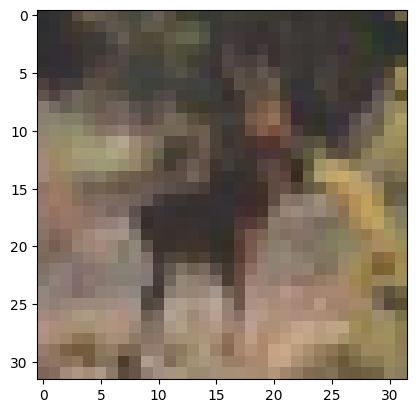

1/1 [==============================] - 0s 11ms/step
Predicted vector: [[0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]]
Actual class: 004_deer ---- Predicted class: Deer
Predicted probabilities: [2.5911223e-10 6.6810545e-15 1.0411325e-04 1.1372934e-05 9.9975508e-01
 2.9292478e-05 5.7808154e-07 9.9474870e-05 2.3424235e-11 4.1445480e-12]


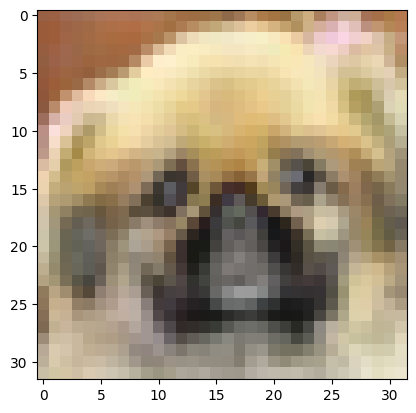

1/1 [==============================] - 0s 16ms/step
Predicted vector: [[0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]]
Actual class: 005_dog ---- Predicted class: Dog
Predicted probabilities: [3.5091813e-07 1.1328395e-07 1.5502886e-04 4.6745045e-03 1.9348312e-05
 9.9194157e-01 3.1952618e-03 1.2015027e-05 1.9269332e-07 1.5736059e-06]


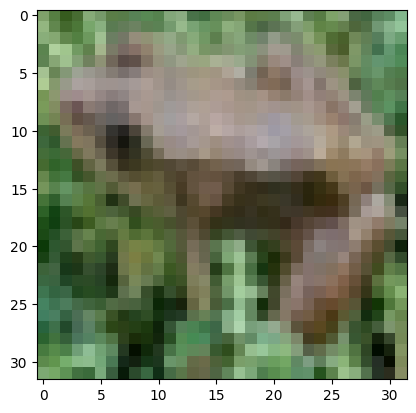

1/1 [==============================] - 0s 10ms/step
Predicted vector: [[0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]]
Actual class: 006_frog ---- Predicted class: Frog
Predicted probabilities: [2.6247025e-07 2.5177924e-09 4.0233371e-04 2.9863408e-04 1.0204381e-02
 3.2069434e-05 9.8906201e-01 2.3440826e-07 1.1114228e-09 7.9803158e-08]


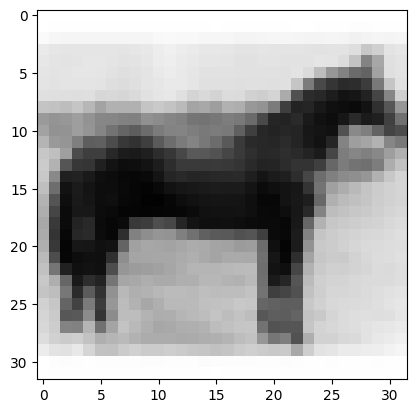

1/1 [==============================] - 0s 12ms/step
Predicted vector: [[0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]]
Actual class: 007_horse ---- Predicted class: Horse
Predicted probabilities: [4.21761559e-09 5.11480344e-13 4.94175534e-10 5.11539220e-08
 1.50122014e-06 2.25206131e-05 2.33243915e-12 9.99975920e-01
 1.26487064e-13 1.13891806e-10]


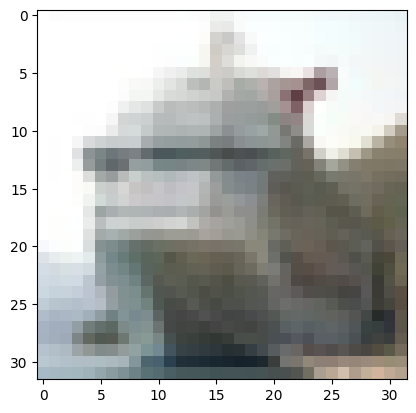

1/1 [==============================] - 0s 11ms/step
Predicted vector: [[0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]]
Actual class: 008_ship ---- Predicted class: Ship
Predicted probabilities: [7.45206838e-03 3.43465625e-04 1.19967284e-04 1.52945810e-04
 3.76421776e-05 6.16241380e-07 4.55989993e-06 4.75226329e-07
 9.88657176e-01 3.23104905e-03]


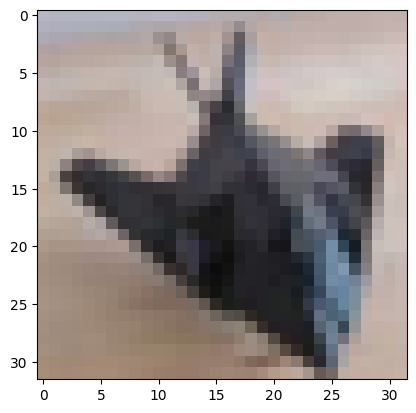

1/1 [==============================] - 0s 11ms/step
Predicted vector: [[1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]
Actual class: 000_airplane ---- Predicted class: Airplane
Predicted probabilities: [9.9110293e-01 2.0950763e-05 3.4745939e-03 9.9210802e-04 2.0094300e-03
 1.4851423e-04 4.0723330e-07 8.3990680e-04 1.3044672e-03 1.0667270e-04]


In [16]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import random
from tensorflow import keras
import os

# Carrega o modelo gerado
model = keras.models.load_model('models/ModelS_without_dataAugmentation.h5')

# Função para prever a classe de uma imagem
def predict_image_class(label):
    # Diretório das imagens de treino
    img_dir = f'../train/{label}'
    
    # Lista de ficheiros de imagem no diretório
    image_files = [f for f in os.listdir(img_dir) if f.endswith(('.png', '.jpg', '.jpeg'))]
    
    # Seleciona uma imagem aleatória da lista
    random_image = random.choice(image_files)
    img_path = os.path.join(img_dir, random_image)
    
    # Carrega e exibe a imagem
    img = tf.keras.preprocessing.image.load_img(img_path, target_size=(IMG_SIZE, IMG_SIZE))
    plt.imshow(img)
    plt.show()
    
    # Prepara a imagem para a Prediction
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    
    # Realiza a Prediction
    predictions = model.predict(img_array)

    # Vetor de probabilidades estatísticas
    predicted_probabilities = predictions[0]
    
    # Determina a classe prevista
    predicted_class_index = np.argmax(predictions)
    
    # Vetor de Precitions
    predicted_vector = np.zeros_like(predictions)
    predicted_vector[0, predicted_class_index] = 1
    
    # índices de classes para as labels
    class_labels = {
        0: "Airplane",
        1: "Automobile",
        2: "Bird",
        3: "Cat",
        4: "Deer",
        5: "Dog",
        6: "Frog",
        7: "Horse",
        8: "Ship",
        9: "Truck"
    }
    
    # Obtém a label da classe prevista
    predicted_label = class_labels[predicted_class_index]
    
    # Exibe os resultados
    print(f"Predicted vector: {predicted_vector}")
    print(f"Actual class: {label} ---- Predicted class: {predicted_label}")
    print(f"Predicted probabilities: {predicted_probabilities}")


# Lista de labels para prever
labels = ['009_truck', '001_automobile', '002_bird', '003_cat', '004_deer', '005_dog', '006_frog', '007_horse', '008_ship', '000_airplane']

# Realiza predicitons para cada rótulo na lista (1 exemplo para cada classe)
for label in labels:
    predict_image_class(label)